In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [24]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
proj_temp = calc_temps('2017-08-01', '2017-08-07')
proj_temp[0][1]

79.25

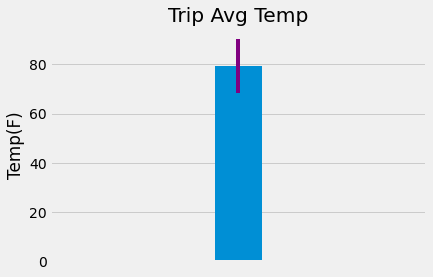

In [111]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
err = proj_temp[0][2] - proj_temp[0][0]
plt.bar(x=0, height=proj_temp[0][1], width=0.5)
plt.title("Trip Avg Temp")
plt.xlim(-2, 2)
plt.ylabel("Temp(F)")
plt.xticks([])
plt.errorbar(x=0, y=proj_temp[0][1], yerr=err, ecolor='purple')
plt.savefig("Images/avg_temp.png")
plt.show()

### Daily Rainfall Average

In [110]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_per_st = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
prcp_per_st = session.query(Measurement.station, func.sum(Measurement.prcp)).\
                filter(Measurement.date >= '2016-08-01', Measurement.date <= '2016-08-07').\
                group_by(Measurement.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()
rain_per_st_df = pd.DataFrame(rain_per_st)
rain_per_st_df
prcp_per_st_df = pd.DataFrame(prcp_per_st, columns=['station', 'prcp'])
prcp_per_st_df

joined_df = pd.merge(rain_per_st_df, prcp_per_st_df, on='station', how='left')
joined_df.sort_values('prcp', ascending=False)

,station,name,latitude,longitude,elevation,prcp
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,6.02
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.65
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.59
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.30
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.03
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.57
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.18
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,NaN
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,NaN


In [60]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [99]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start='8/1/2017', end='8/7/2017')
date_range
# Strip off the year and save a list of strings in the format %m-%d
date_range2 = date_range.strftime("%m-%d")

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for x in date_range2:
    normals.append(daily_normals(x)[0])
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [101]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame.from_records(normals, columns=['tmin', 'tavg', 'tmax']).set_index(date_range2)
df

,tmin,tavg,tmax
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


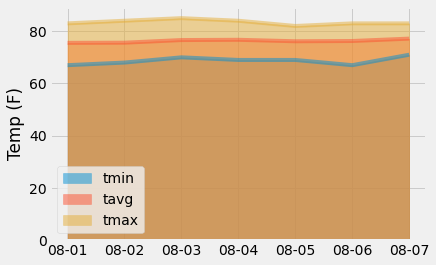

In [104]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)
plt.ylabel('Temp (F)')
plt.savefig("Images/daily_n")
plt.show()

## Close Session

In [105]:
session.close()